## Stochastic Gradient Descent (SGD) Classifier Model

### Connect to data sources and import libraries for modeling




In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 51.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import sqlite3
import csv

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from dmba import classificationSummary
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn import metrics

from imblearn.over_sampling import SMOTE

%matplotlib inline

# Turn off warnings for ease of viewing
import warnings
warnings.filterwarnings("ignore")

# Set option to see all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

no display found. Using non-interactive Agg backend


### Connect to SQL database and bring in the transformed_data table

In [4]:
# Connect to the database
conn = sqlite3.connect('/content/drive/My Drive/MS-ADS Capstone Project/data/hr_case_study.db')

##### Query general_data table ##### 
# Create cursor object and query table
cursor = conn.cursor()
cursor.execute('SELECT * FROM transformed_data AS d')

# Identify the column names for dataframe
col_names = [desc[0] for desc in cursor.description]

# Fetch all rows from the query and store in dataframe
rows = cursor.fetchall()
transformed_sql= pd.DataFrame(rows, columns = col_names)

# Close the cursor and connection objects
cursor.close()
conn.close()

In [5]:
transformed_sql.head()

,index,Unnamed: 0,Education,EmployeeID,JobLevel,NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,time_id,mean_time,median_time,max_time,num_times_over_9hours,num_times_over_11hours,%_under_8,%_over_9,%_over_11,clipped_TrainingTimesLastYear,clipped_NumCompaniesWorked,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,log_clipped_num_times_less_8hours,log_total_days,log_num_times_over_9hours,log_num_times_over_11hours,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Attrition_Yes,Gender_Male,log_AgeBeganWorking,log_WorkingDaysPerYear
0,0,0,0.25,1,1,1.0,0.666667,0.0,0.666667,1.000000,0.333333,1,0 days 07:22:26.896551724,0 days 07:23:00,0 days 07:57:00,0,0,1.0,0.0,0.0,1.00,0.125,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0.992462,0.847162,0.0,0.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.858668,0.926953
1,1,1,0.00,2,1,0.0,0.333333,1.0,0.666667,0.333333,1.000000,2,0 days 07:43:03.813559322,0 days 07:43:00,0 days 08:34:00,0,0,1.0,0.0,0.0,0.50,0.000,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,0.959652,0.791635,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.305588,0.626674
2,2,2,0.75,3,4,1.0,0.666667,0.0,0.333333,0.333333,0.000000,3,0 days 07:00:48.595041322,0 days 06:59:00,0 days 07:59:00,0,0,1.0,0.0,0.0,0.25,0.125,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1.000000,0.859920,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.337215,0.663684
3,3,3,1.00,4,3,3.0,0.333333,0.0,1.000000,1.000000,0.666667,4,0 days 07:11:36.510638298,0 days 07:11:00,0 days 07:53:00,0,0,1.0,0.0,0.0,1.00,0.375,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0.994756,0.851046,0.0,0.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.425729,0.581211
4,4,4,0.00,5,1,4.0,0.666667,0.0,1.000000,0.000000,0.666667,5,0 days 08:00:22.530612245,0 days 07:58:00,0 days 08:50:00,0,0,1.0,0.0,0.0,0.25,0.500,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0.884149,0.663853,0.0,0.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.305588,0.528216


In [6]:
# Columns to keep and create the final base analytics table
cols_to_keep = ['Attrition_Yes','Education','JobLevel','clipped_NumCompaniesWorked','JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                'JobSatisfaction','WorkLifeBalance','%_over_11','clipped_TrainingTimesLastYear','log_Age','log_StockOptionLevel','log_YearsSinceLastPromotion',
                'log_TotalWorkingYears','log_YearsAtCompany','log_MonthlyIncome','log_PercentSalaryHike','log_DistanceFromHome','log_clipped_YearsWithCurrentManager',
                'BusinessTravel_Travel_Frequently','Department_Research & Development','Department_Sales','JobRole_Manager','JobRole_Sales Representative',
                'EducationField_Technical Degree']

# Assign the columns to keep to the model_df variable
model_df = transformed_sql[cols_to_keep]
model_df.head()

,Attrition_Yes,Education,JobLevel,clipped_NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,%_over_11,clipped_TrainingTimesLastYear,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,BusinessTravel_Travel_Frequently,Department_Research & Development,Department_Sales,JobRole_Manager,JobRole_Sales Representative,EducationField_Technical Degree
0,0,0.25,1,0.125,0.666667,0.0,0.666667,1.000000,0.333333,0.0,1.00,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0,0,1,0,0,0
1,1,0.00,1,0.000,0.333333,1.0,0.666667,0.333333,1.000000,0.0,0.50,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,1,1,0,0,0,0
2,0,0.75,4,0.125,0.666667,0.0,0.333333,0.333333,0.000000,0.0,0.25,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1,1,0,0,0,0
3,0,1.00,3,0.375,0.333333,0.0,1.000000,1.000000,0.666667,0.0,1.00,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0,1,0,0,0,0
4,0,0.00,1,0.500,0.666667,0.0,1.000000,0.000000,0.666667,0.0,0.25,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0,1,0,0,0,0


### Create SGD Classifier

#### Test Train Split Test Method

In [7]:
# Assign the independent and dependent variables
y = model_df['Attrition_Yes']
X = model_df.drop(columns = ['Attrition_Yes'])

# partitioning data into 90% train and 10% test, and then will further split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 12345)

# using 80 / 20 split for train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, random_state = 12345)

In [8]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt.value_counts()

0    2347
1    2347
Name: Attrition_Yes, dtype: int64

In [9]:
# Validate size of train and test data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2822, 25)
(2822,)
(882, 25)
(882,)


In [10]:
# Loop to create the model 
from sklearn.linear_model import SGDClassifier

# Define the loss functions
loss_f = ['log', 'hinge', 'perceptron']
scores_list = []
avg_list = []


for i, loss in enumerate(loss_f):
  models = SGDClassifier(loss = loss).fit(X_train,y_train)
  cv = cross_val_score(models, X_train, y_train, cv=5, scoring='accuracy')
  scores_list.append({'Model': models, 'cv': cv})
  avg_list.append({'Model': models, 'Avg CrossVal': cv.mean()})

In [11]:
pd.DataFrame(avg_list)

,Model,Avg CrossVal
0,SGDClassifier(loss='log'),0.825318
1,SGDClassifier(),0.797350
2,SGDClassifier(loss='perceptron'),0.668717


In [12]:
# Create the alpha values
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []

# Test both L1 and L2 Regularization
for a in alphas:
  l1clf = SGDClassifier(loss ='log', penalty= 'l1', alpha = a).fit(X,y)
  l2clf = SGDClassifier(loss ='log', penalty= 'l2', alpha = a).fit(X,y)
  l1cv = cross_val_score(l1clf, X, y, scoring = 'accuracy', cv = 5)
  l2cv = cross_val_score(l2clf, X, y, scoring = 'accuracy', cv =5 )
  results.append({'alpha': a, 'log L1': l1cv.mean(), 'log L2': l2cv.mean()})

l1l2clf = pd.DataFrame(results)
l1l2clf

,alpha,log L1,log L2
0,0.00001,0.838095,0.848980
1,0.00010,0.848526,0.848299
2,0.00100,0.851927,0.851020
3,0.01000,0.838776,0.839909
4,0.10000,0.838776,0.838776
5,1.00000,0.838776,0.838776
6,10.00000,0.838776,0.838776
7,100.00000,0.703175,0.567574
8,1000.00000,0.703175,0.703175


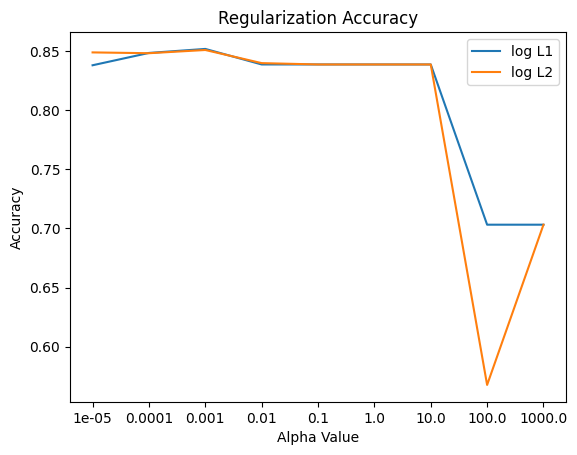

In [13]:
# Show the test and train error rate
x = l1l2clf['alpha']
x_values = range(len(x))
plt.plot(l1l2clf['log L1'], label = 'log L1')
plt.plot(l1l2clf['log L2'], label  ='log L2')

plt.xticks(x_values, x)
plt.title('Regularization Accuracy')
plt.xlabel('Alpha Value')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [14]:
# Create the alpha values
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []

# Loop through each alpha value in the SGDClassifier with log loss and l1
for a in alphas:
  l1clf = SGDClassifier(loss ='log', penalty= 'l1', alpha = a).fit(X_train,y_train)
  print('Finished training, alpha=%f' % a)
  l1cv = cross_val_score(l1clf, X_train, y_train, scoring = 'accuracy', cv = 5, n_jobs=5)

  print('Finished 5-fold CV, alpha=%f' % a)
  results.append({'alpha': a, 'log L1': l1cv.mean()})
  results # append 'alpha' and 'log L1'

# Append results toa dataframe
l1_acc = pd.DataFrame(results)

Finished training, alpha=0.000010
Finished 5-fold CV, alpha=0.000010
Finished training, alpha=0.000100
Finished 5-fold CV, alpha=0.000100
Finished training, alpha=0.001000
Finished 5-fold CV, alpha=0.001000
Finished training, alpha=0.010000
Finished 5-fold CV, alpha=0.010000
Finished training, alpha=0.100000
Finished 5-fold CV, alpha=0.100000
Finished training, alpha=1.000000
Finished 5-fold CV, alpha=1.000000
Finished training, alpha=10.000000
Finished 5-fold CV, alpha=10.000000
Finished training, alpha=100.000000
Finished 5-fold CV, alpha=100.000000
Finished training, alpha=1000.000000
Finished 5-fold CV, alpha=1000.000000


In [15]:
# Review the alpha values with L1 loss function
l1_acc

,alpha,log L1
0,0.00001,0.718226
1,0.00010,0.838054
2,0.00100,0.844085
3,0.01000,0.831680
4,0.10000,0.831680
5,1.00000,0.831680
6,10.00000,0.831680
7,100.00000,0.698936
8,1000.00000,0.699055


In [16]:
# Use the best Stochastic Gradient Descent classifier to build specific model
sgcd = SGDClassifier(loss ='log', penalty= 'l1', alpha = 0.00100).fit(X_train,y_train)
sgcd_pred = sgcd.predict(X_test)
print('accuracy %2.2f ' % accuracy_score(y_test,sgcd_pred))

accuracy 0.87 


In [17]:
cm_mod_test_sgcd = confusion_matrix(y_test, sgcd_pred)
labels_mod = ['Yes','No']
test_results_sgcd = pd.DataFrame(cm_mod_test_sgcd, index = labels_mod, 
                                  columns = labels_mod)
test_results_sgcd

,Yes,No
Yes,751,3
No,115,13


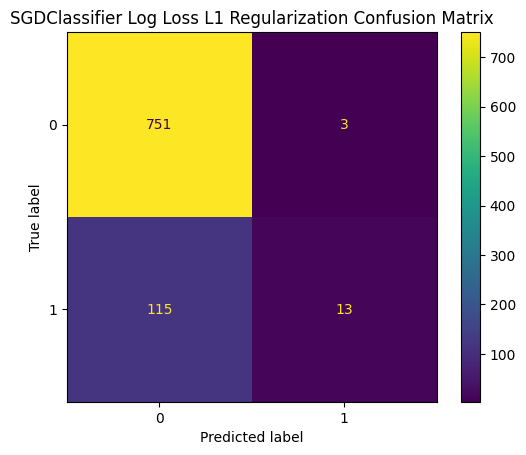

In [18]:
# Create the confusion matrix for teseting data
confusion_matrix_sgd = metrics.confusion_matrix(y_test,sgcd_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_sgd)
cm_display.plot()

# Show the confusion matrix
plt.title("SGDClassifier Log Loss L1 Regularization Confusion Matrix")
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print('\nClassification Report on SGDClassifier - Log Loss - L2:\n')
print(classification_report(y_test, sgcd_pred))
print('\n')


Classification Report on SGDClassifier - Log Loss - L2:

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       754
           1       0.81      0.10      0.18       128

    accuracy                           0.87       882
   macro avg       0.84      0.55      0.55       882
weighted avg       0.86      0.87      0.82       882



